In [11]:
from elasticsearch import Elasticsearch, helpers
from elasticsearch.dsl import Search
from elasticsearch.helpers import bulk
import pandas as pd
import numpy as np
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
from pprint import pprint
import json
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from pandas.util import hash_pandas_object as pdhash

pd.set_option('display.max_columns', None)

In [4]:
# Establish connection to Elasticsearch
conn = Elasticsearch(
    ['https://192.168.145.101:9200'], 
    ca_certs=False, 
    verify_certs=False,
    # basic_auth=('jupyter', 'jupyter@seconi.com'),
    basic_auth=('nialliceh@gmail.com', 'nialliceh3108'),
)

print(conn.info())
# print(conn.indices.get_data_stream(name="logs-zeek*"))

{'name': 'sec-oni', 'cluster_name': 'securityonion', 'cluster_uuid': 'Mgfl_yJjRFaq4qzC1E76_g', 'version': {'number': '8.18.4', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '43b24f613cf25fd3f3369df174e9535a99512aec', 'build_date': '2025-07-16T22:07:56.651816195Z', 'build_snapshot': False, 'lucene_version': '9.12.1', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


/home/mbelin/vdt/c2-beacon-detection/venv/lib/python3.12/site-packages/elasticsearch/_sync/client/__init__.py:403: SecurityWarning: Connecting to 'https://192.168.145.101:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(


In [ ]:
# Read log from Elasticsearch to DataFrame

zlog = Search(using=conn, index='logs-zeek-so')

conn_log = zlog.query("term", **{"event.dataset": "zeek.conn"})
http_log = zlog.query("term", **{"event.dataset": "zeek.http"})
dns_log = zlog.query("term", **{"event.dataset": "zeek.dns"})
ssl_log = zlog.query("term", **{"event.dataset": "zeek.ssl"})

conn_12h = conn_log.filter('range', **{'@timestamp': {'gte': 'now-12h', 'lt': 'now'}})
http_12h = http_log.filter('range', **{'@timestamp': {'gte': 'now-12h', 'lt': 'now'}})
dns_12h = dns_log.filter('range', **{'@timestamp': {'gte': 'now-12h', 'lt': 'now'}})
ssl_12h = ssl_log.filter('range', **{'@timestamp': {'gte': 'now-12h', 'lt': 'now'}})

conn_df = pd.DataFrame()
for hit in conn_12h.scan():
    data = hit.to_dict()['message']
    data = json.loads(data)
    row = pd.DataFrame([data])
    conn_df = pd.concat([conn_df, row], ignore_index=True)

http_df = pd.DataFrame()
for hit in http_12h.scan():
    data = hit.to_dict()['message']
    data = json.loads(data)
    row = pd.DataFrame([data])
    http_df = pd.concat([http_df, row], ignore_index=True)

dns_df = pd.DataFrame()
for hit in dns_12h.scan():
    data = hit.to_dict()['message']
    data = json.loads(data)
    row = pd.DataFrame([data])
    dns_df = pd.concat([dns_df, row], ignore_index=True)

ssl_df = pd.DataFrame()
for hit in ssl_12h.scan():
    data = hit.to_dict()['message']
    data = json.loads(data)
    row = pd.DataFrame([data])
    ssl_df = pd.concat([ssl_df, row], ignore_index=True)


In [36]:
# write dataframe to csv file
conn_df.to_csv('zeek_conn_12h.csv', index=False)
http_df.to_csv('zeek_http_12h.csv', index=False)
dns_df.to_csv('zeek_dns_12h.csv', index=False)
ssl_df.to_csv('zeek_ssl_12h.csv', index=False)

### Start from here if not running SecOni

In [43]:
# read csv file to dataframe
conn_df = pd.read_csv('zeek_conn_12h.csv')
http_df = pd.read_csv('zeek_http_12h.csv')
dns_df = pd.read_csv('zeek_dns_12h.csv')
ssl_df = pd.read_csv('zeek_ssl_12h.csv')

In [13]:
# Đọc file log Zeek vào DataFrame
def read_zeek_log(file_path):
    # Lấy tên cột từ dòng "#fields"
    with open(file_path, "r") as f:
        for line in f:
            if line.startswith("#fields"):
                columns = line.strip().split("\t")[1:]  # bỏ "#fields"
                break

    # Đọc dữ liệu, bỏ các dòng metadata
    df = pd.read_csv(
        file_path,
        sep="\t",
        comment="#",      # bỏ các dòng bắt đầu bằng "#"
        names=columns,    # dùng tên cột lấy từ #fields
        na_values=["-"],  # thay "-" bằng NaN
    )
    return df

path = "./../traffic/log/havoc/"

conn_df = read_zeek_log(path + "conn.log")
http_df = read_zeek_log(path + "http.log")
dns_df = read_zeek_log(path + "dns.log")
ssl_df = read_zeek_log(path + "ssl.log")
x509_df = read_zeek_log(path + "x509.log")

In [372]:
# Group logs by FQDN and source IP to get tsList and dsList
def group_logs(conn_df, http_df, dns_df, ssl_df):
    # uid_to_bytes_map = conn_df[['uid', 'orig_ip_bytes']].drop_duplicates('uid').set_index('uid')['orig_ip_bytes']
    final_df = pd.DataFrame()
    rows = []

    conn_df.sort_values(by=['ts'], inplace=True)
    conn_df['hash'] = conn_df.apply(lambda row: hash((row['id.orig_h'], row['id.resp_h'])), axis=1)
    conn_grouped = conn_df.groupby('hash')
    for name, group in conn_grouped:
        rows.append({
            'log': 'conn',
            'srcIP': group['id.orig_h'].iloc[0],
            'dstIP': group['id.resp_h'].iloc[0],
            'tsList': group["ts"].tolist(),
            'dsList': group['orig_ip_bytes'].tolist(),
            'duration': group['duration'].tolist(),
            'hash': name,
        })
    grcon_df = pd.DataFrame(rows)

    # --- SSL LOG ---
    ssl_df.sort_values(by=['ts'], inplace=True)
    ssl_df['server_name'] = ssl_df['server_name'].fillna(ssl_df['id.resp_h'])
    ssl_df['hash'] = ssl_df.apply(lambda row: hash((row['id.orig_h'], row['server_name'])), axis=1)
    ssl_grouped = ssl_df.groupby('hash')
    for name, group in ssl_grouped:
        rows.append({
            'log': 'ssl',
            'srcIP': group['id.orig_h'].iloc[0],
            'dstIP': group['id.resp_h'].iloc[0],
            'fqdn': group['server_name'].iloc[0],
            'tsList': group["ts"].tolist(),
            # 'dsList': group['uid'].map(uid_to_bytes_map).tolist(),
            'hash': name,
        })
    grssl_df = pd.DataFrame(rows)


    # --- HTTP LOG ---
    http_df.sort_values(by=['ts'], inplace=True)
    # If 'host' is missing, use id.resp_h instead
    http_df['host'] = http_df['host'].fillna(http_df['id.resp_h'])
    http_df['hash'] = http_df.apply(lambda row: hash((row['id.orig_h'], row['host'])), axis=1)
    # Group by hash
    http_grouped = http_df.groupby('hash')
    for name, group in http_grouped:
        rows.append({
            'log': 'http',
            'srcIP': group['id.orig_h'].iloc[0],
            'dstIP': group['id.resp_h'].iloc[0],
            'fqdn': group['host'].iloc[0],   # this could be host or resp_h
            'tsList': group["ts"].tolist(),
            # 'dsList': group['uid'].map(uid_to_bytes_map).tolist(),
            'hash': name,
        })
    grhttp_df = pd.DataFrame(rows)


    # --- DNS LOG ---
    dns_df.sort_values(by=['ts'], inplace=True)
    dns_df['query'] = dns_df['query'].fillna(dns_df['id.resp_h'])
    dns_df['hash'] = dns_df.apply(lambda row: hash((row['id.orig_h'], row['query'])), axis=1)
    dns_grouped = dns_df.groupby('hash')
    for name, group in dns_grouped:
        rows.append({
            'log': 'dns',
            'srcIP': group['id.orig_h'].iloc[0],
            'dstIP': group['id.resp_h'].iloc[0],
            'fqdn': group['query'].iloc[0],
            'tsList': group["ts"].tolist(),
            # 'dsList': group['uid'].map(uid_to_bytes_map).tolist(),
            'hash': name,
        })
    grdns_df = pd.DataFrame(rows)

    # final_df = pd.DataFrame(rows)
    # return final_df
    return grcon_df, grssl_df, grhttp_df, grdns_df

In [378]:
# Group logs by FQDN and source IP to get tsList and dsList
def group_logs(conn_df, http_df, dns_df, ssl_df):
    uid_to_bytes_map = conn_df[['uid', 'orig_ip_bytes']].drop_duplicates('uid').set_index('uid')['orig_ip_bytes']
    final_df = pd.DataFrame()
    rows = []

    conn_df.sort_values(by=['ts'], inplace=True)
    conn_df['hash'] = conn_df.apply(lambda row: hash((row['id.orig_h'], row['id.resp_h'])), axis=1)
    conn_grouped = conn_df.groupby('hash')
    for name, group in conn_grouped:
        rows.append({
            'log': 'conn',
            'srcIP': group['id.orig_h'].iloc[0],
            'dstIP': group['id.resp_h'].iloc[0],
            'fqdn': group['id.resp_h'].iloc[0],
            'tsList': group["ts"].tolist(),
            'dsList': group['orig_ip_bytes'].tolist(),
            'hash': name,
        })

    # --- SSL LOG ---
    ssl_df.sort_values(by=['ts'], inplace=True)
    ssl_df['server_name'] = ssl_df['server_name'].fillna(ssl_df['id.resp_h'])
    ssl_df['hash'] = ssl_df.apply(lambda row: hash((row['id.orig_h'], row['server_name'])), axis=1)
    ssl_grouped = ssl_df.groupby('hash')
    for name, group in ssl_grouped:
        rows.append({
            'log': 'ssl',
            'srcIP': group['id.orig_h'].iloc[0],
            'dstIP': group['id.resp_h'].iloc[0],
            'fqdn': group['server_name'].iloc[0],
            'tsList': group["ts"].tolist(),
            'dsList': group['uid'].map(uid_to_bytes_map).tolist(),
            'hash': name,
        })


    # --- HTTP LOG ---
    http_df.sort_values(by=['ts'], inplace=True)
    # If 'host' is missing, use id.resp_h instead
    http_df['host'] = http_df['host'].fillna(http_df['id.resp_h'])
    http_df['hash'] = http_df.apply(lambda row: hash((row['id.orig_h'], row['host'])), axis=1)
    # Group by hash
    http_grouped = http_df.groupby('hash')
    for name, group in http_grouped:
        rows.append({
            'log': 'http',
            'srcIP': group['id.orig_h'].iloc[0],
            'dstIP': group['id.resp_h'].iloc[0],
            'fqdn': group['host'].iloc[0],   # this could be host or resp_h
            'tsList': group["ts"].tolist(),
            'dsList': group['uid'].map(uid_to_bytes_map).tolist(),
            'hash': name,
        })


    # --- DNS LOG ---
    dns_df.sort_values(by=['ts'], inplace=True)
    dns_df['query'] = dns_df['query'].fillna(dns_df['id.resp_h'])
    dns_df['hash'] = dns_df.apply(lambda row: hash((row['id.orig_h'], row['query'])), axis=1)
    dns_grouped = dns_df.groupby('hash')
    for name, group in dns_grouped:
        rows.append({
            'log': 'dns',
            'srcIP': group['id.orig_h'].iloc[0],
            'dstIP': group['id.resp_h'].iloc[0],
            'fqdn': group['query'].iloc[0],
            'tsList': group["ts"].tolist(),
            'dsList': group['uid'].map(uid_to_bytes_map).tolist(),
            'hash': name,
        })

    final_df = pd.DataFrame(rows)
    return final_df

final_df = group_logs(conn_df, http_df, dns_df, ssl_df)
final_df

,log,srcIP,dstIP,fqdn,tsList,dsList,hash
0,conn,10.0.0.1,172.253.118.138,172.253.118.138,"[1759312553.380637, 1759312612.515951]","[5589, 11755]",-9152063420983649676
1,conn,10.0.0.1,172.217.194.101,172.217.194.101,"[1759302305.511978, 1759312529.131166]","[6498, 3815]",-9149651404780690819
2,conn,::,ff02::1:ff03:72b7,ff02::1:ff03:72b7,"[1759301531.135951, 1759304179.991204, 1759312...","[72, 72, 144, 72]",-9128283710788020178
3,conn,10.0.0.1,142.251.12.113,142.251.12.113,"[1759302304.599078, 1759302304.699759, 1759312...","[3357, 6583, 7267]",-9081017629013908379
4,conn,10.0.0.1,52.168.112.66,52.168.112.66,"[1759307480.069422, 1759307960.391184, 1759308...","[10946, 10950, 10950, 10946]",-9069086354733438323
...,...,...,...,...,...,...,...
838,dns,10.0.0.1,8.8.8.8,ssl.gstatic.com,"[1759292819.129554, 1759292829.307284, 1759292...","[347, 347, 1641, 1641, 263, 402, 402, 1754, 68...",8978451261365152799
839,dns,10.0.0.1,8.8.8.8,ms-vscode-remote.gallery.vsassets.io,"[1759293402.199754, 1759293402.199963]","[8614, 8614]",9039097622221325609
840,dns,10.0.0.1,8.8.8.8,proxy.individual.githubcopilot.com,"[1759302635.267437, 1759302635.267441, 1759302...","[80, 80, 80, 80]",9097330279741771629
841,dns,10.0.0.1,8.8.8.8,www.googleadservices.com,"[1759293302.666316, 1759294161.537333, 1759294...","[6179, 70, 70]",9124141161692402603


In [374]:
grcon_df, grssl_df, grhttp_df, grdns_df = group_logs(conn_df, http_df, dns_df, ssl_df)

In [ ]:
grcon_df['con_cnt'] = grcon_df['tsList'].apply(len)

# extract rows from conn_df where con_cnt < 5, save this dataframe to csv file for the next analysis
# save_df.to_csv('next_batch.csv', index=False)

,log,srcIP,dstIP,tsList,dsList,duration,hash
0,conn,192.168.28.131,142.250.71.161,[1755774837.011623],[285],[195.212862],-8427902656262331144
1,conn,192.168.28.129,192.168.28.254,[1755774856.913102],[312],[0.00237],-8331397092112665960
2,conn,192.168.28.131,4.213.25.242,[1755774997.839688],[41],[5.1e-05],-8119967274313612561
3,conn,192.168.28.129,142.250.71.195,[1755774948.404634],[3823],[119.119349],-8012323472095502720
4,conn,192.168.28.131,23.53.210.166,"[1755775024.706083, 1755775025.836964, 1755775...","[41664, 32522, 6939, 6858, 6854, 6935, 10867, ...","[2.410159, 1.289591, 0.274909, 0.272012, 0.269...",-7873830110533795569
...,...,...,...,...,...,...,...
77,conn,192.168.28.131,224.0.0.251,[1755774844.645308],[172],[0.000282],7648384592537562332
78,conn,192.168.28.131,43.250.0.64,"[1755774830.731889, 1755774831.19864]","[161, 161]","[31.461754, 30.995132]",8179104633296491755
79,conn,192.168.28.131,192.168.28.2,"[1755774844.63964, 1755774848.809568, 17557748...","[288, 76, 76, 76, 61, 150, 61, 61, 61, 57, 60,...","[3.0232, 0.000694, 0.000467, 0.000353, 0.00034...",8819005079968458461
80,conn,192.168.28.131,23.53.210.57,"[1755775027.873049, 1755775027.873203, 1755775...","[1684, 1317, 1278, 1118, 1764, 1118, 1153]","[0.247081, 0.28002, 0.279953, 0.305617, 0.2798...",8894216669635925236


# conn.log

In [44]:
conn_df

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,community_id,orig_mac_oui
0,1.759314e+09,CdI85g4pf9Wpks53H,10.0.0.1,45107,8.8.8.8,53,udp,dns,0.014001,50.0,154.0,SF,True,False,0,Dd,1,78,1,182,1:Usid+qqZE9t5Hbbx1tfJRxcGsZA=,Dell Inc.
1,1.759314e+09,Cp3gr7ajWAYz7rTY,10.0.0.1,59204,169.254.169.254,80,tcp,NaN,2.025084,0.0,0.0,S0,True,True,0,S,3,180,0,0,1:cjWcGfawCRsuJyFuxlKWRlPVRNQ=,Dell Inc.
2,1.759314e+09,CnYBxi4bAvnVToEG7f,10.0.0.2,50775,239.255.255.250,1900,udp,NaN,3.003241,692.0,0.0,S0,True,False,0,D,4,804,0,0,1:zHXdocboloJPdFLePU/c01ZZPj4=,"LCFC(Hefei) Electronics Technology co., ltd"
3,1.759314e+09,CMSdHC2n2MVon7VTWg,10.0.0.1,55622,8.8.8.8,53,udp,dns,0.006076,37.0,103.0,SF,True,False,0,Dd,1,65,1,131,1:o+S+3INP2RS8D990ObhkWGcxRWI=,Dell Inc.
4,1.759314e+09,CD50yw2nEcLykpAPx6,10.0.0.1,57838,8.8.8.8,53,udp,dns,0.014008,50.0,66.0,SF,True,False,0,Dd,1,78,1,94,1:RT4+aqIeY7YhZp35fXIJgGPUBuc=,Dell Inc.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4708,1.759294e+09,ClcdGp22MRpQEslMO1,10.0.0.1,40466,172.253.118.95,443,udp,"ssl,quic",0.179452,7399.0,6241.0,SF,True,False,0,Dd,12,7735,16,6689,1:/FEwAdB9yO5ojlKGHC6nyvwNghc=,Dell Inc.
4709,1.759294e+09,CqEjOW3jNXoIzn76Y5,10.0.0.1,60600,142.250.4.97,443,udp,"ssl,quic",0.123495,4024.0,8834.0,SF,True,False,0,Dd,7,4220,11,9142,1:4m2UfQjHig/JPVqhWTqT83APogY=,Dell Inc.
4710,1.759294e+09,CYfG2A2PX0N5nOssD6,10.0.0.1,35245,64.233.170.139,443,udp,"ssl,quic",0.217450,6299.0,4778.0,SF,True,False,0,Dd,11,6607,11,5086,1:aXyrk0rgAqmmdOzIWlp9CXbowZ0=,Dell Inc.
4711,1.759294e+09,CzlMBNf5TGqrQ03X9,10.0.0.1,59091,142.251.10.91,443,udp,"ssl,quic",0.142350,4219.0,6939.0,SF,True,False,0,Dd,10,4499,13,7303,1:LM/P7njz+StcKAPho3odbvarUmM=,Dell Inc.


In [ ]:
# 1. remove logs where dstIP in whitelist
WHITELIST_IP = ['8.8.8.8', '1.1.1.1']
conn_df = conn_df.loc[~conn_df['id.resp_h'].isin(WHITELIST_IP)]
conn_df

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,community_id,orig_mac_oui
1,1.759314e+09,Cp3gr7ajWAYz7rTY,10.0.0.1,59204,169.254.169.254,80,tcp,NaN,2.025084,0.0,0.0,S0,True,True,0,S,3,180,0,0,1:cjWcGfawCRsuJyFuxlKWRlPVRNQ=,Dell Inc.
2,1.759314e+09,CnYBxi4bAvnVToEG7f,10.0.0.2,50775,239.255.255.250,1900,udp,NaN,3.003241,692.0,0.0,S0,True,False,0,D,4,804,0,0,1:zHXdocboloJPdFLePU/c01ZZPj4=,"LCFC(Hefei) Electronics Technology co., ltd"
5,1.759314e+09,CEJunU36EdvW1KEuol,10.0.0.1,33206,13.107.5.93,443,tcp,ssl,4.421556,1440.0,7798.0,SF,True,False,0,ShADdaFfr,13,1980,17,8490,1:1viaKWoPSDV6muKTPMf3TDblj2g=,Dell Inc.
8,1.759314e+09,CCRT763vSl9O5JRty1,10.0.0.1,59220,169.254.169.254,80,tcp,NaN,2.086774,0.0,0.0,S0,True,True,0,S,3,180,0,0,1:VmvLViBZlHZn3zjfPfqEo3tS9uA=,Dell Inc.
9,1.759314e+09,CXxLyF4o9HX06OJgid,10.0.0.1,47688,13.107.246.73,443,tcp,ssl,90.826409,2798.0,68392.0,SF,True,False,0,ShADadfF,37,4730,60,71520,1:OGOHrDHY0d+VpWqthzKYWB2VmYM=,Dell Inc.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4708,1.759294e+09,ClcdGp22MRpQEslMO1,10.0.0.1,40466,172.253.118.95,443,udp,"ssl,quic",0.179452,7399.0,6241.0,SF,True,False,0,Dd,12,7735,16,6689,1:/FEwAdB9yO5ojlKGHC6nyvwNghc=,Dell Inc.
4709,1.759294e+09,CqEjOW3jNXoIzn76Y5,10.0.0.1,60600,142.250.4.97,443,udp,"ssl,quic",0.123495,4024.0,8834.0,SF,True,False,0,Dd,7,4220,11,9142,1:4m2UfQjHig/JPVqhWTqT83APogY=,Dell Inc.
4710,1.759294e+09,CYfG2A2PX0N5nOssD6,10.0.0.1,35245,64.233.170.139,443,udp,"ssl,quic",0.217450,6299.0,4778.0,SF,True,False,0,Dd,11,6607,11,5086,1:aXyrk0rgAqmmdOzIWlp9CXbowZ0=,Dell Inc.
4711,1.759294e+09,CzlMBNf5TGqrQ03X9,10.0.0.1,59091,142.251.10.91,443,udp,"ssl,quic",0.142350,4219.0,6939.0,SF,True,False,0,Dd,10,4499,13,7303,1:LM/P7njz+StcKAPho3odbvarUmM=,Dell Inc.


In [ ]:
# 2. check if known service match common port
service_port = {
    'http': 80,
    'ssl': 443,
    'quic': 443,
    'dns': 53,
}

conn_df['weird_port'] = 0

for index, row in conn_df.iterrows():
    # check if service is not nan
    if pd.notna(row['service']):
        service = row['service'].split(',')[0]
        if service in service_port:
            if row['id.resp_p'] != service_port[service]:
                conn_df.at[index, 'weird_port'] = 1

,srcIP,dstIP,timeList,dataList,durList
0,10.0.0.1,104.16.100.215,"[1759302677.721335, 1759302678.759507, 1759302...","[21593, 525859, 1769]","[1.5059161186218262, 10.060832023620604, 1.115..."
1,10.0.0.1,104.16.101.215,"[1759302676.740929, 1759302679.298547, 1759302...","[47323, 1467, 1469]","[1.177235126495361, 0.2041518688201904, 1.0123..."
2,10.0.0.1,104.16.80.73,"[1759302313.258511, 1759302348.43392]","[3586, 2363]","[390.6743679046631, 86.33698511123657]"
3,10.0.0.1,104.16.98.215,"[1759302680.339352, 1759302682.030912]","[18097, 1915]","[2.442138195037842, 1.2196719646453855]"
4,10.0.0.1,104.16.99.215,"[1759302675.772435, 1759302683.690988]","[1677, 1467]","[1.0514249801635742, 1.1380338668823242]"
...,...,...,...,...,...
404,fe80::3113:d8f7:b14f:cd9c,ff02::2,"[1759294006.149671, 1759294105.719591, 1759294...","[48, 288, 48, 48, 48, 48, 240, 48, 48, 48, 48,...","[nan, 112.40919017791748, nan, nan, nan, nan, ..."
405,fe80::3113:d8f7:b14f:cd9c,ff02::fb,"[1759294006.820725, 1759294106.381061, 1759294...","[377, 1132, 189, 189, 189, 189, 189, 189, 1132...","[0.8079559803009033, 28.94943189620972, nan, n..."
406,fe80::f2a4:8a20:4403:72b7,ff02::16,"[1759294005.26781, 1759294104.664265, 17593015...","[192, 192, 192, 192, 384, 192, 192]","[0.2796518802642822, 0.704254150390625, 0.3918..."
407,fe80::f2a4:8a20:4403:72b7,ff02::2,"[1759294005.308156, 1759294104.776407, 1759294...","[48, 240, 48, 48, 48, 48, 48, 240, 48, 48, 48,...","[nan, 59.52720904350281, nan, nan, nan, nan, n..."


In [ ]:
# group by srcIP, dstIP

rows = []

conn_df = conn_df.sort_values(by=['ts'])
conn_grouped = conn_df.groupby(['id.orig_h', 'id.resp_h'])
for name, group in conn_grouped:
    rows.append({
        'srcIP': name[0],
        'dstIP': name[1],
        'timeList': group["ts"].tolist(),
        'dataList': group['orig_ip_bytes'].tolist(),
        'durList': group['duration'].tolist(),
        'weird_port': max(group['weird_port'].tolist()),
    })
grcon_df = pd.DataFrame(rows)
grcon_df

,srcIP,dstIP,timeList,dataList,durList,weird_port
0,10.0.0.1,104.16.100.215,"[1759302677.721335, 1759302678.759507, 1759302...","[21593, 525859, 1769]","[1.5059161186218262, 10.060832023620604, 1.115...",0
1,10.0.0.1,104.16.101.215,"[1759302676.740929, 1759302679.298547, 1759302...","[47323, 1467, 1469]","[1.177235126495361, 0.2041518688201904, 1.0123...",0
2,10.0.0.1,104.16.80.73,"[1759302313.258511, 1759302348.43392]","[3586, 2363]","[390.6743679046631, 86.33698511123657]",0
3,10.0.0.1,104.16.98.215,"[1759302680.339352, 1759302682.030912]","[18097, 1915]","[2.442138195037842, 1.2196719646453855]",0
4,10.0.0.1,104.16.99.215,"[1759302675.772435, 1759302683.690988]","[1677, 1467]","[1.0514249801635742, 1.1380338668823242]",0
...,...,...,...,...,...,...
404,fe80::3113:d8f7:b14f:cd9c,ff02::2,"[1759294006.149671, 1759294105.719591, 1759294...","[48, 288, 48, 48, 48, 48, 240, 48, 48, 48, 48,...","[nan, 112.40919017791748, nan, nan, nan, nan, ...",0
405,fe80::3113:d8f7:b14f:cd9c,ff02::fb,"[1759294006.820725, 1759294106.381061, 1759294...","[377, 1132, 189, 189, 189, 189, 189, 189, 1132...","[0.8079559803009033, 28.94943189620972, nan, n...",1
406,fe80::f2a4:8a20:4403:72b7,ff02::16,"[1759294005.26781, 1759294104.664265, 17593015...","[192, 192, 192, 192, 384, 192, 192]","[0.2796518802642822, 0.704254150390625, 0.3918...",0
407,fe80::f2a4:8a20:4403:72b7,ff02::2,"[1759294005.308156, 1759294104.776407, 1759294...","[48, 240, 48, 48, 48, 48, 48, 240, 48, 48, 48,...","[nan, 59.52720904350281, nan, nan, nan, nan, n...",0


In [ ]:
# 3. check IoC list for dstIP
with open('ioc.txt', 'r') as f:
    ioc_list = {line.strip() for line in f if line.strip()}

grcon_df.loc[:, 'score'] = np.where(grcon_df['dstIP'].isin(ioc_list), 1, np.nan)


In [ ]:
# --- Extract domain ---
def extract_domain(fqdn):
    if pd.isna(fqdn): return ''
    parts = fqdn.lower().split('.')
    return '.'.join(parts[-2:]) if len(parts) >= 2 else fqdn

KNOWN_SERVICES = [
    'google.com','youtube.com','microsoft.com','cloudflare.com',
    'amazonaws.com','github.com','googleapis.com','windows.net','azure.com','facebook.com', 'githubcopilot.com', 'digicert.com'
]

final_df['domain'] = final_df['fqdn'].apply(extract_domain)
sus_df = final_df[~final_df['domain'].isin(KNOWN_SERVICES)]
sus_df

,log,srcIP,dstIP,fqdn,tsList,dsList,hash,domain
0,conn,10.0.0.1,172.253.118.138,None,"[1759312553.380637, 1759312612.515951]","[5589, 11755]",-9152063420983649676,
1,conn,10.0.0.1,172.217.194.101,None,"[1759302305.511978, 1759312529.131166]","[6498, 3815]",-9149651404780690819,
2,conn,::,ff02::1:ff03:72b7,None,"[1759301531.135951, 1759304179.991204, 1759312...","[72, 72, 144, 72]",-9128283710788020178,
3,conn,10.0.0.1,142.251.12.113,None,"[1759302304.599078, 1759302304.699759, 1759312...","[3357, 6583, 7267]",-9081017629013908379,
4,conn,10.0.0.1,52.168.112.66,None,"[1759307480.069422, 1759307960.391184, 1759308...","[10946, 10950, 10950, 10946]",-9069086354733438323,
...,...,...,...,...,...,...,...,...
838,dns,10.0.0.1,8.8.8.8,ssl.gstatic.com,"[1759292819.129554, 1759292829.307284, 1759292...","[347, 347, 1641, 1641, 263, 402, 402, 1754, 68...",8978451261365152799,gstatic.com
839,dns,10.0.0.1,8.8.8.8,ms-vscode-remote.gallery.vsassets.io,"[1759293402.199754, 1759293402.199963]","[8614, 8614]",9039097622221325609,vsassets.io
840,dns,10.0.0.1,8.8.8.8,proxy.individual.githubcopilot.com,"[1759302635.267437, 1759302635.267441, 1759302...","[80, 80, 80, 80]",9097330279741771629,githubcopilot.com
841,dns,10.0.0.1,8.8.8.8,www.googleadservices.com,"[1759293302.666316, 1759294161.537333, 1759294...","[6179, 70, 70]",9124141161692402603,googleadservices.com


In [271]:
# sub functions

def ts_to_interval(ts):
    return np.diff(ts) 

In [272]:
# # Calc autocorrelation using np.correlate
# def calc_autocorrelation(data, resolution=1.0):
#     """
#     Phân tích một danh sách timestamp bằng phương pháp tự tương quan (autocorrelation)
#     để xác định mức độ lặp lại của tín hiệu (khả năng là beaconing).

#     Args:
#         data (list or np.array): Danh sách các timestamp (dưới dạng Unix timestamp hoặc tương tự).
#         resolution (float): Độ phân giải thời gian (tính bằng giây) để tạo chuỗi tín hiệu. 
#                              Mặc định là 1 giây.

#     Returns:
#         float: Một điểm số từ 0.0 đến 1.0 đại diện cho mức độ tương đồng. 
#                Giá trị càng gần 1, tín hiệu càng có tính chu kỳ mạnh.
#     """
#     # 1. Kiểm tra đầu vào
#     if len(data) < 6:  # Cần đủ dữ liệu để phân tích có ý nghĩa
#         return 0.0

#     data = np.array(sorted(data))
#     duration = data[-1] - data[0]
    
#     if duration <= 0:
#         return 0.0

#     # 2. Chuyển đổi data thành một chuỗi tín hiệu nhị phân (0 và 1)
#     # Kích thước của chuỗi tín hiệu sẽ là tổng thời gian chia cho độ phân giải
#     num_bins = int(np.ceil(duration / resolution))
#     signal = np.zeros(num_bins)
    
#     # "bin" các timestamp vào đúng vị trí trong chuỗi tín hiệu
#     indices = ((data - data[0]) / resolution).astype(int)
#     # Đảm bảo index không vượt quá giới hạn
#     indices = np.minimum(indices, num_bins - 1)
#     signal[indices] = 1

#     # 3. Tính toán tự tương quan (Autocorrelation)
#     # mode='full' sẽ trả về kết quả tương quan ở mọi điểm chồng chéo
#     autocorr = np.correlate(signal, signal, mode='full')
    
#     # Chúng ta chỉ quan tâm đến nửa sau của kết quả (các độ trễ dương)
#     autocorr = autocorr[len(autocorr) // 2:]

#     # 4. Tính toán điểm số
#     # Đỉnh đầu tiên (tại lag=0) luôn là lớn nhất, tương ứng với năng lượng của tín hiệu.
#     # Chúng ta tìm đỉnh cao thứ hai, đại diện cho chu kỳ lặp lại mạnh nhất.
    
#     # Bỏ qua đỉnh ở lag=0
#     if len(autocorr) < 2:
#         return 0.0
        
#     peak_at_zero = autocorr[0]
    
#     if peak_at_zero == 0:
#         return 0.0

#     # Tìm đỉnh cao nhất trong phần còn lại của chuỗi
#     second_highest_peak = np.max(autocorr[1:]) if len(autocorr) > 1 else 0

#     # Điểm số là tỷ lệ giữa đỉnh chu kỳ và đỉnh năng lượng.
#     # Tỷ lệ này cho biết mức độ mạnh mẽ của thành phần lặp lại so với toàn bộ tín hiệu.
#     score = second_highest_peak / peak_at_zero
    
#     return score

In [ ]:
import requests, whois, math, datetime, time, os

VT_API_KEY = "de67b0efc0280c891eacd25c4715554a9f6b87e6b998f47483085b0970ba9a05"
CACHE_FILE = "domain_cache.csv"
CACHE_EXPIRY_DAYS = 7  # chỉ tra lại nếu cache quá 7 ngày

# === Load Zeek logs ===
df = pd.read_csv("conn_dns.csv")

# --- Shannon entropy ---
def shannon_entropy(s):
    if not s: return 0
    probs = [s.count(c)/len(s) for c in set(s)]
    return -sum(p * math.log2(p) for p in probs)


df['domain'] = df['fqdn'].apply(extract_domain)
df['entropy'] = df['fqdn'].apply(lambda x: shannon_entropy(x.split('.')[0]) if isinstance(x, str) else 0)
df['known_service'] = df['domain'].isin(KNOWN_SERVICES)
freq = df.groupby(['srcIP', 'domain']).size().reset_index(name='count')
df = df.merge(freq, on=['srcIP', 'domain'])

# --- Load cache ---
if os.path.exists(CACHE_FILE):
    cache = pd.read_csv(CACHE_FILE)
else:
    cache = pd.DataFrame(columns=['domain', 'domain_age_days', 'vt_score', 'last_checked'])

def is_cache_valid(row):
    if pd.isna(row['last_checked']): return False
    try:
        last = datetime.datetime.fromisoformat(row['last_checked'])
        return (datetime.datetime.now() - last).days < CACHE_EXPIRY_DAYS
    except Exception:
        return False

def get_domain_age(domain):
    try:
        w = whois.whois(domain)
        created = w.creation_date
        if isinstance(created, list): created = created[0]
        if isinstance(created, datetime.datetime):
            return (datetime.datetime.now() - created).days
    except Exception:
        return None

def vt_reputation(domain):
    try:
        url = f"https://www.virustotal.com/api/v3/domains/{domain}"
        headers = {"x-apikey": VT_API_KEY}
        r = requests.get(url, headers=headers, timeout=10)
        if r.status_code != 200:
            return None
        data = r.json()
        mal = data["data"]["attributes"]["last_analysis_stats"]["malicious"]
        sus = data["data"]["attributes"]["last_analysis_stats"]["suspicious"]
        return mal + sus
    except Exception:
        return None

# --- Lookup with cache ---
domains = df['domain'].dropna().unique()
results = []

for d in domains:
    row = cache[cache['domain'] == d]
    if not row.empty and is_cache_valid(row.iloc[0]):
        age = row.iloc[0]['domain_age_days']
        vt = row.iloc[0]['vt_score']
        print(f"[CACHE] {d:30} | Age={age} | VT={vt}")
    else:
        age = get_domain_age(d)
        vt = vt_reputation(d)
        print(f"[LOOKUP] {d:30} | Age={age} | VT={vt}")
        new_entry = {
            'domain': d,
            'domain_age_days': age,
            'vt_score': vt,
            'last_checked': datetime.datetime.now().isoformat()
        }
        cache = pd.concat([cache[cache['domain'] != d], pd.DataFrame([new_entry])], ignore_index=True)
        time.sleep(15)  # tránh bị limit VT API free

    results.append((d, age, vt))

# --- Save cache ---
cache.to_csv(CACHE_FILE, index=False)
print(f"\n[+] Cache updated: {CACHE_FILE}")

# --- Merge back ---
reputation_df = pd.DataFrame(results, columns=['domain', 'domain_age_days', 'vt_score'])
df = df.merge(reputation_df, on='domain', how='left')

# --- Scoring ---
def score_row(r):
    s = 0
    if r['entropy'] > 4.0: s += 15
    if r['count'] > 10: s += 10
    if r['known_service']: s -= 15
    if pd.notna(r['domain_age_days']) and r['domain_age_days'] < 30: s += 10
    if pd.notna(r['vt_score']) and r['vt_score'] >= 3: s += 40
    return s

df['risk_score'] = df.apply(score_row, axis=1)
df['risk_label'] = df['risk_score'].apply(lambda x: 'malicious' if x >= 30 else ('suspicious' if x >= 10 else 'benign'))

# --- Output suspicious results ---
out = df[df['risk_label'] != 'benign'][['srcIP','fqdn','domain','entropy','count','domain_age_days','vt_score','risk_score','risk_label']].drop_duplicates()
out.to_csv("suspicious_domains.csv", index=False)
print("\n[+] Results saved to suspicious_domains.csv")

In [297]:
# Calc autocorrelation v2 using statsmodels
def calc_autocorrelation_v2(intervals: list) -> float:
    """
    Phân tích một danh sách các timestamp để phát hiện hành vi beaconing (định kỳ).

    Hàm này tính toán các khoảng thời gian nghỉ giữa các timestamp, sau đó sử dụng
    hàm tự tương quan (ACF) để tìm ra các mẫu lặp lại. Điểm số trả về
    là giá trị tự tương quan dương lớn nhất (không tính lag 0), đại diện
    cho cường độ của tín hiệu định kỳ.

    Args:
        intervals: Một danh sách các số float hoặc int đại diện cho khoảng thời gian giữa các timestamp.

    Returns:
        Một giá trị float trong khoảng [0, 1].
        - Gần 1: Dấu hiệu beaconing rất mạnh, có chu kỳ rõ rệt.
        - Gần 0: Traffic có vẻ ngẫu nhiên, không có dấu hiệu beaconing.
    """

    if len(intervals) < 5:
        return 0.0

    # 2. Tiền xử lý: Sắp xếp và tính các khoảng nghỉ (intervals)
    # sorted_ts = np.array(sorted(timestamps))
    # intervals = np.diff(sorted_ts)

    # 3. Tính toán tự tương quan (ACF)
    # nlags: số độ trễ cần tính. len(intervals) // 2 là một lựa chọn hợp lý.
    # fft=True: sử dụng biến đổi Fourier nhanh để tăng tốc độ tính toán.
    try:
        autocorr_values = acf(intervals, nlags=len(intervals), fft=True)
    except Exception:
        # Xử lý trường hợp có lỗi tính toán (ví dụ: phương sai bằng 0)
        return 0.0

    # 4. Xác định điểm số: Lấy giá trị tương quan dương lớn nhất
    # Bỏ qua giá trị đầu tiên (lag=0) vì nó luôn bằng 1.
    if len(autocorr_values) < 2:
        return 0.0
        
    max_corr = np.max(autocorr_values[1:])
    
    # Chỉ quan tâm đến tương quan dương, vì beaconing là sự lặp lại
    score = max(0, max_corr)

    return score

In [274]:
# Calc Bowkey skewness and Median Absolute Deviation

# muc do dong deu cua du lieu
def calc_bowley_skewness(data):
    if len(data) < 5:
        return 0.0
    
    q1, q2, q3 = np.percentile(data, [25, 50, 75])

    if (q3 - q1) == 0:
        return 0.0
    
    bowley_skewness = (q3 + q1 - 2 * q2) / (q3 - q1)

    score = 1 - abs(bowley_skewness) # 1 is symmetric
    return score

# muc do phan tan so voi trung vi
def calc_median_absolute_deviation(data):
    if len(data) < 5:
        return 0.0

    mad = np.median(np.abs(data - np.median(data)))
    cv_mad = mad / np.median(data) if np.median(data) != 0 else 0

    score = 1.0 / (1.0 + cv_mad) # 1 is consistent
    return score

In [242]:
final_df[final_df['dstIP'] == '68.183.138.51']
# test_df[test_df['srcIP'] == '10.0.0.2']
final_df[final_df['dstIP'] == '192.168.99.245']

,log,srcIP,dstIP,fqdn,tsList,dsList,hash
19,conn,192.168.28.131,192.168.99.245,192.168.99.245,"[1755774815.931699, 1755774816.44297, 17557748...","[52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 5...",-3315689652324733382
60,conn,192.168.28.129,192.168.99.245,192.168.99.245,"[1755774817.976066, 1755774819.548729, 1755774...","[599, 653, 639, 26573, 1616, 1374, 8792, 1415]",3495501347888756407
105,ssl,192.168.28.129,192.168.99.245,192.168.99.245,"[1755774893.269739, 1755774894.288458, 1755774...","[1616, 1374, 8792, 1415]",3495501347888756407
116,http,192.168.28.129,192.168.99.245,192.168.99.245:8000,"[1755774817.976776, 1755774819.54941, 17557748...","[599, 653, 639, 26573]",-6110243530159426908


In [ ]:
ts_df = final_df.drop(columns=['dsList'])
ts_df['bowley_skewness'] = ts_df['tsList'].apply(lambda x: calc_bowley_skewness(ts_to_interval(x)))
ts_df['mad'] = ts_df['tsList'].apply(lambda x: calc_median_absolute_deviation(ts_to_interval(x)))
ts_df['auto_corr'] = ts_df['tsList'].apply(lambda x: calc_autocorrelation_v2(ts_to_interval(x)))
ts_df = ts_df[(ts_df['bowley_skewness'] > 0) & (ts_df['mad'] > 0) & (ts_df['auto_corr'] > 0)]
ts_df['tsScore'] = (ts_df['bowley_skewness'] + ts_df['mad'] + ts_df['auto_corr']) / 3
ts_df.sort_values(by='tsScore', ascending=False)

,log,srcIP,dstIP,fqdn,tsList,hash,bowley_skewness,mad,auto_corr,tsScore
199,conn,10.0.0.1,239.255.255.250,239.255.255.250,"[1759292813.816358, 1759292933.814202, 1759293...",-373555798027870075,0.981292,0.999984,0.321071,0.767449
448,ssl,10.0.0.1,74.125.68.100,accounts.youtube.com,"[1759293314.708277, 1759293915.580891, 1759294...",-4146629867943834260,0.879911,0.998950,0.339743,0.739535
610,dns,10.0.0.1,8.8.8.8,lscr.io,"[1759302670.124953, 1759302670.124955, 1759302...",-5595301386112981514,0.973353,0.677446,0.541830,0.730877
617,dns,10.0.0.1,8.8.8.8,www3.l.google.com,"[1759293298.923757, 1759293314.728972, 1759293...",-5216889094696890180,0.839619,0.998672,0.318791,0.719028
193,conn,10.0.0.2,239.255.255.250,239.255.255.250,"[1759304182.84185, 1759304302.843373, 17593044...",-789916740890161210,0.666667,0.999979,0.487416,0.718020
...,...,...,...,...,...,...,...,...,...,...
618,dns,10.0.0.1,8.8.8.8,storage.googleapis.com,"[1759294515.234828, 1759294515.234911, 1759302...",-5208549332765128343,0.000251,0.501616,0.050026,0.183964
684,dns,10.0.0.1,8.8.8.8,drive.google.com,"[1759301573.177978, 1759301573.177981, 1759301...",-860993975337497508,0.008930,0.500002,0.037910,0.182281
741,dns,10.0.0.1,8.8.8.8,marketplace.visualstudio.com,"[1759293398.446627, 1759293398.446628, 1759294...",2196284995150472413,0.000004,0.502304,0.030841,0.177716
588,dns,10.0.0.1,8.8.8.8,onedscolprdwus03.westus.cloudapp.azure.com,"[1759293921.288694, 1759293926.68245, 17592939...",-6960736837973083492,0.004254,0.500000,0.027521,0.177258


In [383]:
ds_df = final_df.drop(columns=['tsList'])
ds_df['bowley_skewness'] = ds_df['dsList'].apply(lambda x: calc_bowley_skewness(x))
ds_df['mad'] = ds_df['dsList'].apply(lambda x: calc_median_absolute_deviation(x))
ds_df = ds_df[(ds_df['bowley_skewness'] > 0) & (ds_df['mad'] > 0)]
ds_df['dsScore'] = (ds_df['bowley_skewness'] + ds_df['mad']) / 2
ds_df.sort_values(by='dsScore', ascending=False)
ds_df.head(20)

,log,srcIP,dstIP,fqdn,dsList,hash,bowley_skewness,mad,dsScore
10,conn,10.0.0.1,35.241.39.74,35.241.39.74,"[3227, 4868, 3138, 753, 4945]",-8865074923642052532,0.102890,0.662901,0.382895
21,conn,10.0.0.1,185.125.190.97,185.125.190.97,"[356, 420, 460, 420, 420, 356, 356, 356]",-8344627658131333716,1.000000,0.923810,0.961905
23,conn,10.0.0.1,64.233.170.95,64.233.170.95,"[13322, 9055, 300, 4093, 7668, 3036, 8464, 120...",-8303573804875611049,0.933111,0.735164,0.834138
24,conn,10.0.0.1,104.18.32.47,104.18.32.47,"[8215, 8235, 8617, 8536, 8116, 8546, 8316, 878...",-8256146983466205086,0.234604,0.974874,0.604739
32,conn,10.0.0.1,74.125.200.94,74.125.200.94,"[11632, 3665, 4490, 3925, 3671, 52102, 5106, 4...",-7819821486359314902,0.796627,0.850335,0.823481
37,conn,10.0.0.1,150.171.73.16,150.171.73.16,"[3645, 3720, 9531, 10089, 3653, 9467]",-7538771642791976391,0.999615,0.691686,0.845651
41,conn,10.0.0.1,74.125.24.95,74.125.24.95,"[12548, 9053, 300, 300, 120, 120, 60, 60, 60, ...",-7405890465027040881,0.089619,0.555556,0.322587
61,conn,10.0.0.1,13.107.213.73,13.107.213.73,"[3992, 5296, 4910, 5244, 5320, 4910, 5180, 485...",-6107857899410800578,0.907268,0.958821,0.933045
74,conn,10.0.0.1,185.199.108.154,185.199.108.154,"[2541, 19752, 2556, 2588, 2528]",-5702826096946779790,0.638298,0.989164,0.813731
75,conn,10.0.0.1,142.251.10.94,142.251.10.94,"[14274, 3817, 2944, 3709, 3888, 4968, 3889, 51...",-5561357946667622957,0.378271,0.864468,0.621369


0.3702404819718875
0.7923870983892394
0.07806792120917183


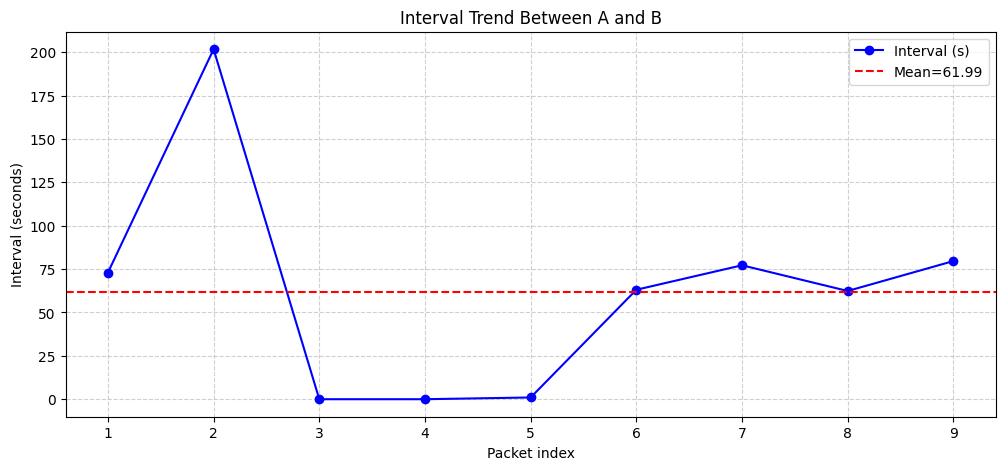

In [322]:
# Visualize timestamp trend
tsList = ts_df.loc[554, 'tsList'][150:200] # http
tsList = ts_df.loc[368, 'tsList'][170:180] # conn

intervals = np.diff(tsList)
print(calc_bowley_skewness(intervals))
print(calc_median_absolute_deviation(intervals))
print(calc_autocorrelation_v2(intervals))

# X là số thứ tự gói (1..n-1)
x = np.arange(1, len(intervals) + 1)

# Vẽ biểu đồ đường
plt.figure(figsize=(12, 5))
plt.plot(x, intervals, marker='o', linestyle='-', color='blue', label="Interval (s)")
plt.axhline(np.mean(intervals), color='red', linestyle='--', label=f"Mean={np.mean(intervals):.2f}")

plt.xlabel("Packet index")
plt.ylabel("Interval (seconds)")
plt.title("Interval Trend Between A and B")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

In [385]:
# cacl scores

def calc_timestamp_score(tsList):
    intervals = ts_to_interval(tsList)
    bowley_skewness = calc_bowley_skewness(intervals)
    mad = calc_median_absolute_deviation(intervals)
    autocorr = calc_autocorrelation_v2(intervals)

    score = (bowley_skewness + mad + autocorr) / 3
    return score

def calc_data_size_score(byteList):
    bowley_skewness = calc_bowley_skewness(byteList)
    mad = calc_median_absolute_deviation(byteList)

    score = (bowley_skewness + mad) / 2
    return score

In [388]:
grouped_df = final_df.copy()
grouped_df['tsScore'] = grouped_df['tsList'].apply(lambda x: calc_timestamp_score(x))
grouped_df['dsScore'] = grouped_df['dsList'].apply(lambda x: calc_data_size_score(x))
grouped_df.sort_values(by=['tsScore', 'dsScore'], ascending=False)
grouped_df['finalScore'] = (grouped_df['tsScore'] + grouped_df['dsScore']) / 2
grouped_df[['srcIP', 'dstIP', 'fqdn', 'finalScore']].sort_values(by='finalScore', ascending=False)

# group by srcIP and dstIP to get max finalScore
ip_pair_df = grouped_df.groupby(['srcIP', 'dstIP']).agg({
    'finalScore': 'max',
}).reset_index()

In [ ]:
ip_pair_df.sort_values(by='finalScore', ascending=False)

# keep rows with finalScore > 0
sus_ip_pairs = ip_pair_df[ip_pair_df['finalScore'] > 0]
sus_ip_pairs

,srcIP,dstIP,finalScore
4,10.0.0.1,104.16.99.215,0.385223
5,10.0.0.1,104.18.32.47,0.655166
6,10.0.0.1,104.18.36.169,0.638829
7,10.0.0.1,104.18.39.21,0.659625
9,10.0.0.1,104.208.16.88,0.248904
...,...,...,...
405,fe80::3113:d8f7:b14f:cd9c,ff02::2,0.517136
406,fe80::3113:d8f7:b14f:cd9c,ff02::fb,0.475351
407,fe80::f2a4:8a20:4403:72b7,ff02::16,0.543434
408,fe80::f2a4:8a20:4403:72b7,ff02::2,0.521269


In [7]:
index_name = "beacon_score_test_2"

mapping = {
    "mappings": {
        "properties": {
            "srcIP": {"type": "ip"},
            "dstIP": {"type": "ip"},
            "finalScore": {"type": "float"},
            "@timestamp": {"type": "date"},
        }
    }
}

# create index safely
conn.options(ignore_status=[400]).indices.create(index=index_name, body=mapping)

# add timestamp
df.loc[:, "timestamp"] = pd.Timestamp.now(tz="Asia/Bangkok")

# prepare bulk actions
actions = [
    {
        "_index": index_name,
        "_source": {
            "srcIP": row["srcIP"],
            "dstIP": row["dstIP"],
            "finalScore": float(row["finalScore"]),
            "@timestamp": row["timestamp"].isoformat(),
        },
    }
    for _, row in df.iterrows()
]

helpers.bulk(conn, actions)

(18, [])

In [ ]:
# calculate multiple metrics, input to ML model, get output as suspicion score

In [5]:
# Tạo timestamps mỗi 12 tiếng
timestamps = pd.date_range("2025-10-01", periods=6, freq="12h", tz="Asia/Bangkok")

# Giả sử có 3 cặp IP
pairs = [
    ("10.0.0.1", "8.8.8.8"),
    ("10.0.0.2", "1.1.1.1"),
    ("10.0.0.3", "8.8.4.4"),
]

rows = []
for ts in timestamps:
    for src, dst in pairs:
        score = np.random.uniform(0, 1)  # random điểm nghi ngờ
        rows.append({"srcIP": src, "dstIP": dst, "finalScore": score, "@timestamp": ts})

df = pd.DataFrame(rows)
df

,srcIP,dstIP,finalScore,@timestamp
0,10.0.0.1,8.8.8.8,0.351629,2025-10-01 00:00:00+07:00
1,10.0.0.2,1.1.1.1,0.983086,2025-10-01 00:00:00+07:00
2,10.0.0.3,8.8.4.4,0.045161,2025-10-01 00:00:00+07:00
3,10.0.0.1,8.8.8.8,0.347826,2025-10-01 12:00:00+07:00
4,10.0.0.2,1.1.1.1,0.142505,2025-10-01 12:00:00+07:00
5,10.0.0.3,8.8.4.4,0.472700,2025-10-01 12:00:00+07:00
6,10.0.0.1,8.8.8.8,0.488997,2025-10-02 00:00:00+07:00
7,10.0.0.2,1.1.1.1,0.516808,2025-10-02 00:00:00+07:00
8,10.0.0.3,8.8.4.4,0.447075,2025-10-02 00:00:00+07:00
9,10.0.0.1,8.8.8.8,0.697940,2025-10-02 12:00:00+07:00
